### Import all neccesary libraries

In [1]:
import pandas as pd
import numpy as np
import geojson
import folium
import glob #library that puts all the csv/excel  files together
from sodapy import Socrata #api for nyc data (used to access eviction dataset)
import warnings

# supress warnings
warnings.filterwarnings('ignore')

### Visual Image of NYC

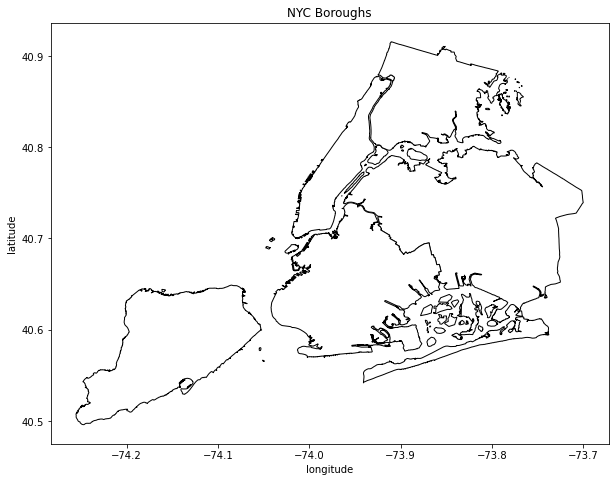

In [2]:
with open('data/new-york-city-boroughs.geojson') as f:
    boro = geojson.load(f)
import matplotlib.pyplot as plt 
from descartes import PolygonPatch
fig = plt.figure(figsize=(10,10)) 
ax = fig.gca()
for i in range(5):
    coords=boro[i]['geometry']
    ax.add_patch(PolygonPatch(coords, fc='#ffffff', ec="#000000", alpha=1, zorder=2 )) 
ax.axis('scaled')
ax.set_title('NYC Boroughs')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
plt.savefig('boros.png')
plt.show()

### Demographics of each zip code

In [8]:
#read acs data
pop2018=pd.read_csv('data/pop_18.csv')

#convert zip code to string to standardize the format
pop2018['zipcode']=pop2018['zip'].astype(str)

#get the demographics from the population
demographics=pop2018.loc[:,['zipcode','white_pct']]

#drop null values
demographics.dropna(inplace=True)

demographics

zipcode  white_pct
0     10001       62.9
1     10002       32.2
2     10003       75.9
3     10004       62.8
4     10005       73.4
..      ...        ...
210   11691       38.9
211   11692       22.6
212   11693       63.3
213   11694       81.3
214   11697       95.4

[186 rows x 2 columns]

In [9]:
# open geojson file about the borders of zip codes
with open('data/zipcodes.geojson') as f:
    gj = geojson.load(f)

#create chloropleth map
m = folium.Map(location=[40.7, -74], zoom_start=10)

folium.Choropleth(
    geo_data=gj,
    name="choropleth",
    data=demographics,
    columns=["zipcode","white_pct"],
    key_on="properties.postalCode",
    fill_color="Oranges",
    fill_opacity=1,
    line_opacity=1,
    nan_fill_color='white',
    legend_name="Percentage of White residents",
#     threshold_scale=[*range(-100,110,20)]
).add_to(m)

m

### income of each zip code

In [10]:
#get the income from the population
income=pop2018.loc[:,['zipcode','median_income']]

#drop null values
income.dropna(inplace=True)

#put a limit on the income to be binned
income['median_income']=income['median_income'].apply(lambda x: x if x < 149999 else 149999)

In [11]:
#create a new chloropleth
m = folium.Map(location=[40.7, -74], zoom_start=10)

folium.Choropleth(
    geo_data=gj,
    name="choropleth",
    data=income,
    columns=["zipcode","median_income"],
    key_on="properties.postalCode",
    fill_color="Reds",
    fill_opacity=1,
    line_opacity=1,
    nan_fill_color='white',
    legend_name="Median Household Income",
    threshold_scale=[*range(0,160000,25000)]
).add_to(m)

m

### Stop and Frisk Datseset

In [12]:
#get all csv file names
filepath='data/sqf'
all_excel_files = glob.glob(filepath + "/*.xlsx")
all_csv_files = glob.glob(filepath + "/*.csv")

#put all csv file names into a list
li = []

for filename in all_csv_files:
    df = pd.read_csv(filename)
    li.append(df)
    
for filename in all_excel_files:
    df = pd.read_excel(filename)
    li.append(df)

#concatenate all excel files into a dataframe
df = pd.concat(li, axis=0)

#merge the x and y coordinates in datasets with different column names 
df['x']=df['STOP_LOCATION_X'].fillna(df['xcoord'])
df['y']=df['STOP_LOCATION_Y'].fillna(df['ycoord'])

#drop null/empty x and y
df=df[df['x']!=' ']
df=df[~df['x'].isnull()]
df=df[df['y']!=' ']
df=df[~df['y'].isnull()]

#convert x and y to integers
df['x']=df['x'].astype(int)
df['y']=df['y'].astype(int)

df

year  pct ser_num datestop timestop recstat inout trhsloc perobs  \
0      2016   41      22  2072016      100       A     O       P      1   
1      2016   10      22  2182016       30       1     O       P      8   
2      2016   66       1  1012016       30       1     I       P      2   
4      2016   79       1  1012016       50       1     O       P      3   
5      2016   73       1  1012016      100       1     O       P      1   
...     ...  ...     ...      ...      ...     ...   ...     ...    ...   
11003   NaN  NaN     NaN      NaN      NaN     NaN   NaN     NaN    NaN   
11004   NaN  NaN     NaN      NaN      NaN     NaN   NaN     NaN    NaN   
11005   NaN  NaN     NaN      NaN      NaN     NaN   NaN     NaN    NaN   
11006   NaN  NaN     NaN      NaN      NaN     NaN   NaN     NaN    NaN   
11007   NaN  NaN     NaN      NaN      NaN     NaN   NaN     NaN    NaN   

          crimsusp  ... STOP_LOCATION_Y STOP_LOCATION_ZIP_CODE  \
0             BURG  ...             NaN                    NaN   
1      MISDEMEANOR  ...             NaN                    NaN   
2              FEL  ...             NaN                    NaN   
4           D.W.I.  ...             NaN                    NaN   
5           FELONY  ...             NaN                    NaN   
...            ...  ...             ...                    ...   
11003          NaN  ...        167946.0                 (null)   
11004          NaN  ...        238628.0                 (null)   
11005          NaN  ...        238628.0                 (null)   
11006          NaN  ...        238628.0                 (null)   
11007          NaN  ...        189462.0                 (null)   

      STOP_LOCATION_PATROL_BORO_NAME STOP_LOCATION_BORO_NAME STOP_ID_ANONY  \
0                                NaN                     NaN           NaN   
1                                NaN                     NaN           NaN   
2                                NaN                     NaN           NaN   
4                                NaN                     NaN           NaN   
5                                NaN                     NaN           NaN   
...                              ...                     ...           ...   
11003                           PBSI           STATEN ISLAND           NaN   
11004                           PBMN               MANHATTAN           NaN   
11005                           PBMN               MANHATTAN           NaN   
11006                           PBMN               MANHATTAN           NaN   
11007                           PBBN                BROOKLYN           NaN   

      ASK_FOR_CONSENT_FLG CONSENT_GIVEN_FLG Stop Frisk Time        x       y  
0                     NaN               NaN             NaN  1013353  234000  
1                     NaN               NaN             NaN   983478  212373  
2                     NaN               NaN             NaN   988340  172111  
4                     NaN               NaN             NaN   998197  187413  
5                     NaN               NaN             NaN  1008226  186458  
...                   ...               ...             ...      ...     ...  
11003                 NaN               NaN        12:43:00   937802  167946  
11004                 NaN               NaN        23:20:00  1001112  238628  
11005                 NaN               NaN        23:20:00  1001112  238628  
11006                 NaN               NaN        23:20:00  1001112  238628  
11007                 NaN               NaN        22:43:00   999081  189462  

[300163 rows x 201 columns]

In [13]:
# # uncomment this to create csv that maps xy to zip code
# import pycrs
# import pyproj
# from functools import lru_cache

# #set formats
# from_crs = pycrs.parse.from_epsg_code(102718).to_proj4() # original xy format
# to_crs=pycrs.parse.from_epsg_code(4326).to_proj4() #normal lat/long format

# #create projects from formats
# fromproj = pyproj.Proj(from_crs)
# toproj = pyproj.Proj(to_crs)

# @lru_cache()
# def xy_to_latlong(x,y):
#     # transform the formats
#     long,lat=pyproj.transform(fromproj, toproj, x,y) #note output is long, lat, instead of lat, long
#     return (lat,long) #switched back to lat,long

In [14]:
# # uncomment this to create csv that maps xy to zip code
# import fiona
# import shapely.geometry

# #read the geojson file and returns a list of shapes (zip codes)
# def read_geojson(path):
#     with fiona.open(path) as fiona_collection:
#         shapes=[] # stores a collection of shapes (zip codes)
#         for i in fiona_collection:
#             shapefile_record = i 

#             # Use Shapely to create the polygon
#             shape = shapely.geometry.asShape(shapefile_record['geometry'] )
            
#             shapes.append((shape,i))
#     return shapes

# #get the list of shapes
# shapes=read_geojson('zipcodes.geojson')

# @lru_cache()
# def latlong_to_zipcode(coord):
#     lat,long=coord #unpack
    
#     #go through each shape
#     for shape,i in shapes:
#         #creat point from long/lat
#         point = shapely.geometry.Point(long,lat) # note this is (longitude, latitude) not (latitude, longitude)
        
#         if shape.contains(point):
#             return (i['properties']['postalCode']) #zip code 

In [15]:
# # uncomment this to create csv that maps xy to zip code
# @lru_cache()
# def xy_to_zipcode(x,y):
#     return latlong_to_zipcode(xy_to_latlong(x,y))

In [16]:
# # uncomment this to create csv that maps xy to zip code

# # get the x and y coordinates and drop null or duplicates
# df_xy=df.loc[:,['x','y']]
# df_xy.dropna(inplace=True)
# df_xy=df_xy.drop_duplicates()

# #convert xy to into 
# df_xy['x']=df_xy['x'].astype(int)
# df_xy['y']=df_xy['y'].astype(int)

# #get the zip codes of each xy coordinate and store in a dataframe
# zipcode=df_xy.apply(lambda k: xy_to_zipcode(k.x, k.y), axis=1)
# df_zipcode=pd.DataFrame(zipcode)

# #merge the xy with zip code
# df_zipcode=df_zipcode.merge(df_xy, left_index=True, right_index=True, how='inner')
# df_zipcode.rename(columns={0:'zipcode'}, inplace=True)

# #save the xy to zip code mapping in a csv file
# df_zipcode.to_csv('data/xy_zipcode_2013to2019.csv')

# df_zipcode

In [18]:
#read csv file for xy to zip code mapping
df_zipcode=pd.read_csv('data/xy_zipcode_2013to2019.csv')

#merge xy with zip codes
frisk_df=df.merge(df_zipcode, left_on=['x','y'], right_on=['x','y'], how='outer')

#drop rows with null zip codes
frisk_df = frisk_df[~frisk_df['zipcode'].isnull()]

#merge the two column names with year data and convert to int
frisk_df['year']= (frisk_df['year'].fillna(frisk_df['YEAR2']))
frisk_df=frisk_df[frisk_df['year']!=' ']
frisk_df['year']=frisk_df['year'].astype(int)

frisk_df['race']=frisk_df['race'].fillna(frisk_df['SUSPECT_RACE_DESCRIPTION'])

frisk_df_suspect=frisk_df[(frisk_df['race']!='W') &  (frisk_df['race']!='WHITE')]

# frisk_df_suspect=frisk_df[(frisk_df['race']=='B') |  (frisk_df['race']=='BLACK')]

frisk_df_suspect

year  pct ser_num datestop timestop recstat inout trhsloc perobs  \
0       2016   41      22  2072016      100       A     O       P      1   
1       2016   41      22  2072016      100       A     O       P      1   
2       2016   41      22  2072016      100       A     O       P      1   
6       2016   10      23  2182016       30       1     O       P      8   
7       2016   10      23  2182016       30       1     O       P      8   
...      ...  ...     ...      ...      ...     ...   ...     ...    ...   
653490  2018  NaN     NaN      NaN      NaN     NaN   NaN     NaN    NaN   
653491  2018  NaN     NaN      NaN      NaN     NaN   NaN     NaN    NaN   
653492  2018  NaN     NaN      NaN      NaN     NaN   NaN     NaN    NaN   
653493  2018  NaN     NaN      NaN      NaN     NaN   NaN     NaN    NaN   
653494  2018  NaN     NaN      NaN      NaN     NaN   NaN     NaN    NaN   

           crimsusp  ... STOP_LOCATION_ZIP_CODE  \
0              BURG  ...                    NaN   
1              BURG  ...                    NaN   
2              BURG  ...                    NaN   
6       MISDEMEANOR  ...                    NaN   
7       MISDEMEANOR  ...                    NaN   
...             ...  ...                    ...   
653490          NaN  ...                 (null)   
653491          NaN  ...                 (null)   
653492          NaN  ...                 (null)   
653493          NaN  ...                 (null)   
653494          NaN  ...                 (null)   

       STOP_LOCATION_PATROL_BORO_NAME STOP_LOCATION_BORO_NAME STOP_ID_ANONY  \
0                                 NaN                     NaN           NaN   
1                                 NaN                     NaN           NaN   
2                                 NaN                     NaN           NaN   
6                                 NaN                     NaN           NaN   
7                                 NaN                     NaN           NaN   
...                               ...                     ...           ...   
653490                           PBQN                  QUEENS           NaN   
653491                           PBQN                  QUEENS           NaN   
653492                           PBSI           STATEN ISLAND           NaN   
653493                           PBSI           STATEN ISLAND           NaN   
653494                           PBSI           STATEN ISLAND           NaN   

       ASK_FOR_CONSENT_FLG CONSENT_GIVEN_FLG Stop Frisk Time        x       y  \
0                      NaN               NaN             NaN  1013353  234000   
1                      NaN               NaN             NaN  1013353  234000   
2                      NaN               NaN             NaN  1013353  234000   
6                      NaN               NaN             NaN   983478  212373   
7                      NaN               NaN             NaN   983478  212373   
...                    ...               ...             ...      ...     ...   
653490                 NaN               NaN        18:30:00  1021548  207179   
653491                 NaN               NaN        18:30:00  1021548  207179   
653492                 NaN               NaN        12:43:00   937802  167946   
653493                 NaN               NaN        12:43:00   937802  167946   
653494                 NaN               NaN        12:43:00   937802  167946   

        zipcode  
0       10474.0  
1       11229.0  
2       10282.0  
6       10001.0  
7          83.0  
...         ...  
653490  11237.0  
653491  11373.0  
653492  10460.0  
653493  11237.0  
653494  10303.0  

[590240 rows x 202 columns]

### frisk count

In [19]:
#groupby to get count 
frisk_count=pd.DataFrame(frisk_df_suspect.groupby(['zipcode','year'])['x'].count())
frisk_count=frisk_count.rename(columns={'x':'frisk_count'})
frisk_count=frisk_count.reset_index()

#standardize zip code
frisk_count['zipcode']=frisk_count['zipcode'].astype(int).astype(str)
frisk_count=frisk_count.dropna()

frisk_count

zipcode  year  frisk_count
0         83  2013          306
1         83  2014          118
2         83  2015           51
3         83  2016           43
4         83  2017           47
...      ...   ...          ...
1272   11697  2015           12
1273   11697  2016            8
1274   11697  2017            2
1275   11697  2018            1
1276   11697  2019            2

[1277 rows x 3 columns]

In [20]:
#create chloropleth map
m = folium.Map(location=[40.7, -74], zoom_start=10)

folium.Choropleth(
    geo_data=gj,
    name="choropleth",
    data=frisk_count[frisk_count['year']==2019],
    columns=["zipcode","frisk_count"],
    key_on="properties.postalCode",
    fill_color="Blues",
    fill_opacity=1,
    line_opacity=1,
    nan_fill_color='white',
    legend_name="Count of Police Encounters",
#     threshold_scale=[*range(-100,110,20)]
).add_to(m)

m

### frisk per capita

In [21]:
#get the zip code and population
pop2018=pd.DataFrame(pop2018.groupby(['zipcode'])['population'].first())

pop2018

population
zipcode            
10001         22924
10002         74993
10003         54682
10004          3028
10005          8831
...             ...
11691         67094
11692         20991
11693         12919
11694         21354
11697          3540

[215 rows x 1 columns]

In [22]:
# groupby and merge with population data
frisk_per=frisk_count.groupby('zipcode').sum().drop(columns='year')
frisk_per=frisk_per.merge(pop2018, left_index=True, right_index=True, how='outer')

#calculate per capita
frisk_per['per_capita']=frisk_per['frisk_count']/frisk_per['population']

#drop null values
frisk_per=frisk_per.dropna()
frisk_per=frisk_per.reset_index()
frisk_per =frisk_per[frisk_per['per_capita']!=np.inf]

frisk_per

zipcode  frisk_count  population  per_capita
0     10001       4075.0     22924.0    0.177761
1     10002       6590.0     74993.0    0.087875
2     10003       4257.0     54682.0    0.077850
3     10004        303.0      3028.0    0.100066
4     10005        131.0      8831.0    0.014834
..      ...          ...         ...         ...
178   11691      10777.0     67094.0    0.160625
179   11692       3082.0     20991.0    0.146825
180   11693       1378.0     12919.0    0.106665
181   11694       1034.0     21354.0    0.048422
182   11697         67.0      3540.0    0.018927

[180 rows x 4 columns]

In [23]:
#create chloropleth map
m = folium.Map(location=[40.7, -74], zoom_start=10)

folium.Choropleth(
    geo_data=gj,
    name="choropleth",
    data=frisk_per,
    columns=["zipcode","per_capita"],
    key_on="properties.postalCode",
    fill_color="Greens",
    fill_opacity=1,
    line_opacity=1,
    nan_fill_color='white',
    legend_name="Per Capita of Police Encounters",
#     threshold_scale=[*range(-100,110,20)]
).add_to(m)

m

### frisk percent change

In [24]:
#select important rows and calculate percent change
frisk_gap=frisk_count[(frisk_count['year']==2017) | (frisk_count['year']==2019)]
frisk_percent=frisk_gap.assign(pct_change=frisk_gap['frisk_count'].pct_change()*100)
frisk_percent=frisk_percent[frisk_percent['year']==2019]

#drop null and infinite values
frisk_percent.dropna(inplace=True)
frisk_percent=frisk_percent[frisk_percent['pct_change']!=np.inf]

#set limits for percent change 
frisk_percent=frisk_percent.reset_index()
frisk_percent['pct_change']=frisk_percent['pct_change'].apply(lambda x: x if x < 99 else 99)
frisk_percent['pct_change']=frisk_percent['pct_change'].apply(lambda x: x if x > -99 else -99)

frisk_percent

index zipcode  year  frisk_count  pct_change
0        6      83  2019           69   46.808511
1       13   10001  2019          169   24.264706
2       20   10002  2019          336    7.348243
3       27   10003  2019          221  -13.671875
4       34   10004  2019           26   99.000000
..     ...     ...   ...          ...         ...
175   1248   11691  2019          408   68.595041
176   1255   11692  2019          103   21.176471
177   1262   11693  2019           83   33.870968
178   1269   11694  2019           42  -12.500000
179   1276   11697  2019            2    0.000000

[180 rows x 5 columns]

In [25]:
#create chloropleth map
m = folium.Map(location=[40.7, -74], zoom_start=10)

folium.Choropleth(
    geo_data=gj,
    name="choropleth",
    data=frisk_percent,
    columns=["zipcode","pct_change"],
    key_on="properties.postalCode",
    fill_color="PuOr",
    fill_opacity=1,
    line_opacity=1,
    nan_fill_color='white',
    legend_name="Percent Change in Police Encounters",
    threshold_scale=[*range(-100,110,20)]
).add_to(m)

m

### Eviction Dataset

In [26]:
client = Socrata("data.cityofnewyork.us", None)

results = client.get("6z8x-wfk4", limit=66402) #unique identifier of the eviction dataset

# Convert to pandas DataFrame
eviction = pd.DataFrame.from_records(results)

#get the eviction year
eviction['executed_date']=pd.to_datetime(eviction['executed_date'])
eviction['year']=eviction['executed_date'].dt.year
eviction['year']=eviction['year'].astype(int)
eviction=eviction[eviction['year']<2070]

eviction['zipcode']=eviction['eviction_zip']

eviction

court_index_number docket_number  \
0             57342/17-2        292815   
1               72072/17         14660   
2               34188/17        067169   
3               81193/17          7272   
4               73116/17        076739   
...                  ...           ...   
66397         0076000/18        116048   
66398         71450/17-1        295618   
66399           67398/16        165938   
66400           57782/17          5453   
66401         62202/19-1        018104   

                             eviction_address eviction_apt_num executed_date  \
0                        60-01 D 194TH STREET               3B    2017-08-16   
1                         118-21 192ND STREET              NaN    2018-03-12   
2                           679 WARING AVENUE              4-D    2018-02-06   
3              562 WEST 149TH STREET - APT 1C               1C    2018-07-30   
4                            6801 19TH AVENUE               4B    2017-12-06   
...                                       ...              ...           ...   
66397            65-06 GRAND CENTRAL  PARKWAY              #1D    2019-04-25   
66398                        134-38 MAPLE AVE               2D    2018-05-09   
66399                      119-60 178TH PLACE     ENTIRE HOUSE    2017-03-03   
66400           352 BEACH 70 STREET 2ND FLOOR              NaN    2017-09-20   
66401  734 EAST 38TH ST. 1ST FLOOR DUPLEX APT              NaN    2019-10-02   

      marshal_first_name marshal_last_name residential_commercial_ind  \
0                 George            Essock                Residential   
1                 Edward             Guida                Residential   
2                 Justin          Grossman                Residential   
3                 Robert          Renzulli                Residential   
4                  Henry             Daley                Residential   
...                  ...               ...                        ...   
66397             Maxine          Chevlowe                Residential   
66398             George            Essock                Residential   
66399             Alfred          Locascio                Residential   
66400             Robert          Renzulli                Residential   
66401             George       Essock, Jr.                Residential   

         borough eviction_zip  ...   latitude   longitude community_board  \
0         QUEENS        11365  ...  40.741455  -73.781796               8   
1         QUEENS        11412  ...  40.690631  -73.758524              12   
2          BRONX        10467  ...  40.861367  -73.868229              11   
3      MANHATTAN        10031  ...  40.828455  -73.947378               9   
4       BROOKLYN        11204  ...  40.616042  -73.989929              11   
...          ...          ...  ...        ...         ...             ...   
66397     QUEENS        11375  ...  40.732738  -73.844226               6   
66398     QUEENS        11355  ...  40.754862  -73.829682               7   
66399     QUEENS        11434  ...  40.686421  -73.765697              12   
66400     QUEENS        11692  ...  40.591794  -73.798978              14   
66401   BROOKLYN        11210  ...        NaN         NaN             NaN   

      council_district census_tract      bin         bbl  \
0                   23         1347  4618116  4071170300   
1                   27          376  4271559  4126080052   
2                   15        33202  2051262  2044260005   
3                    7          233  1062059  1020800056   
4                   47          258  3135020  3055780001   
...                ...          ...      ...         ...   
66397               29          747  4454559  4021867502   
66398               20          853  4115398  4051220022   
66399               27          368  4269284  4124670043   
66400               31          954  4533158  4160810114   
66401              NaN          NaN      NaN         NaN   

                 

### Eviction count

In [27]:
#groupby zipcode and year
eviction_count=pd.DataFrame(eviction.groupby(['zipcode','year'])['eviction_address'].count())
eviction_count=eviction_count.reset_index()
eviction_count=eviction_count.dropna()
eviction_count=eviction_count.rename(columns={'eviction_address':'eviction_count'})

#format zipcodes
eviction_count['zipcode']=eviction_count['zipcode'].astype(int)
eviction_count=eviction_count[eviction_count['zipcode']>10000]
eviction_count['zipcode']=eviction_count['zipcode'].astype(str)

eviction_count

zipcode  year  eviction_count
3     10001  2017             108
4     10001  2018             143
5     10001  2019              84
6     10001  2020              10
7     10001  2021               1
..      ...   ...             ...
762   11694  2019              37
763   11694  2020               4
764   11698  2019               1
765   11753  2017               1
766   12221  2018               1

[764 rows x 3 columns]

In [28]:
#create chloropleth map
m = folium.Map(location=[40.7, -74], zoom_start=10)

folium.Choropleth(
    geo_data=gj,
    name="choropleth",
    data=eviction_count[eviction_count['year']==2019],
    columns=["zipcode","eviction_count"],
    key_on="properties.postalCode",
    fill_color="Blues",
    fill_opacity=1,
    line_opacity=1,
    nan_fill_color='white',
    legend_name="Count of Evictions",
#     threshold_scale=[*range(-100,110,20)]
).add_to(m)

m

### Eviction per capita

In [29]:
#groupby and merge with population 
eviction_per=eviction_count.groupby('zipcode').sum().drop(columns='year')
eviction_per=eviction_per.merge(pop2018, left_index=True, right_index=True, how='outer')

#calculate the per capita
eviction_per['per_capita']=eviction_per['eviction_count']/eviction_per['population']

#drop null values
eviction_per=eviction_per.dropna()
eviction_per=eviction_per.reset_index()
eviction_per =eviction_per[eviction_per['per_capita']!=np.inf]

eviction_per

zipcode  eviction_count  population  per_capita
0     10001           346.0     22924.0    0.015093
1     10002           321.0     74993.0    0.004280
2     10003           159.0     54682.0    0.002908
3     10004            23.0      3028.0    0.007596
4     10005            51.0      8831.0    0.005775
..      ...             ...         ...         ...
185   11436           179.0     20077.0    0.008916
186   11691           867.0     67094.0    0.012922
187   11692           361.0     20991.0    0.017198
188   11693           105.0     12919.0    0.008128
189   11694           138.0     21354.0    0.006462

[180 rows x 4 columns]

In [30]:
#create chloropleth map
m = folium.Map(location=[40.7, -74], zoom_start=10)

folium.Choropleth(
    geo_data=gj,
    name="choropleth",
    data=eviction_per,
    columns=["zipcode","per_capita"],
    key_on="properties.postalCode",
    fill_color="Greens",
    fill_opacity=1,
    line_opacity=1,
    nan_fill_color='white',
    legend_name="Per Capita of Evictions",
#     threshold_scale=[*range(-100,110,20)]
).add_to(m)

m

### Eviction percent change 

In [31]:
#select important rows and caclculate percent change 
eviction_gap=eviction_count[(eviction_count['year']==2017) | (eviction_count['year']==2019)]
eviction_percent=eviction_gap.assign(pct_change=eviction_gap['eviction_count'].pct_change()*100)
eviction_percent=eviction_percent[eviction_percent['year']==2019]

#drop null and infinite values
eviction_percent.dropna(inplace=True)
eviction_percent=eviction_percent[eviction_percent['pct_change']!=np.inf]

#set limits for percent change
eviction_percent=eviction_percent.reset_index()
eviction_percent['pct_change']=eviction_percent['pct_change'].apply(lambda x: x if x < 99 else 99)
eviction_percent['pct_change']=eviction_percent['pct_change'].apply(lambda x: x if x > -99 else -99)

eviction_percent

index zipcode  year  eviction_count  pct_change
0        5   10001  2019              84  -22.222222
1       10   10002  2019              82  -28.070175
2       14   10003  2019              44  -20.000000
3       18   10004  2019               8    0.000000
4       22   10005  2019              17    6.250000
..     ...     ...   ...             ...         ...
192    750   11691  2019             259  -10.996564
193    754   11692  2019             101  -17.213115
194    758   11693  2019              31   -8.823529
195    762   11694  2019              37  -31.481481
196    764   11698  2019               1  -97.297297

[197 rows x 5 columns]

In [32]:
#create chloropleth
m = folium.Map(location=[40.7, -74], zoom_start=10)

folium.Choropleth(
    geo_data=gj,
    name="choropleth",
    data=eviction_percent,
    columns=["zipcode","pct_change"],
    key_on="properties.postalCode",
    fill_color="PuOr",
    fill_opacity=1,
    line_opacity=1,
    nan_fill_color='white',
    legend_name="Percent Change in Evictions",
    threshold_scale=[*range(-100,120,20)]
).add_to(m)

m

### Property Value Dataset

In [34]:
#read prop val csv and drop null and infinite values
prop_val=pd.read_csv('data/prop_data/prop_val_zip.csv')
prop_val=prop_val.drop(columns=['Unnamed: 0','pct_change'])


# #change postal code to integer
prop_val['POSTCODE']=prop_val['POSTCODE'].astype(int).astype(str)

#calculate percent change
prop_gap=prop_val[(prop_val['YEAR']==2013) | (prop_val['YEAR']==2019)]
prop_percent=prop_gap.assign(pct_change=prop_gap['FULLVAL'].pct_change()*100)
prop_percent=prop_percent[prop_percent['YEAR']==2019]

#set limit for percent change
prop_percent['pct_change']=prop_percent['pct_change'].apply(lambda x: x if x < 199 else 199)

prop_percent

POSTCODE  YEAR      FULLVAL  pct_change
10      10001  2019   6073230158   96.077268
19      10002  2019   5888124146   61.730811
28      10003  2019  11093185648   48.262553
37      10004  2019    906636055   29.720303
46      10005  2019   2439786346  128.427913
...       ...   ...          ...         ...
1694    11692  2019   1404473379   43.119917
1703    11693  2019    850223732   12.427320
1712    11694  2019   3006797663   12.817591
1721    11697  2019    423399130    1.702772
1722    12345  2019       742000  -99.824752

[195 rows x 4 columns]

In [35]:
#create chloropleth
m = folium.Map(location=[40.7, -74], zoom_start=10)

folium.Choropleth(
    geo_data=gj,
    name="choropleth",
    data=prop_percent,
    columns=["POSTCODE","pct_change"],
    key_on="properties.postalCode",
    fill_color="PuOr",
    fill_opacity=1,
    line_opacity=1,
    nan_fill_color='white',
    legend_name="Percent Change in Property Value",
#     threshold_scale=[*range(-300,310,100)]
).add_to(m)

m

### Combining datasets

In [36]:
#merge the three datasets together 
frisk_eviction=frisk_per.merge(eviction_per, left_on=['zipcode'], right_on=['zipcode'], how='inner')
prop_val=prop_val.rename(columns={'POSTCODE':'zipcode', 'YEAR':'year'})
combined=frisk_eviction.merge(prop_val, left_on=['zipcode'], right_on=['zipcode'], how='inner')
combined

zipcode  frisk_count  population_x  per_capita_x  eviction_count  \
0      10001       4075.0       22924.0      0.177761           346.0   
1      10001       4075.0       22924.0      0.177761           346.0   
2      10001       4075.0       22924.0      0.177761           346.0   
3      10001       4075.0       22924.0      0.177761           346.0   
4      10001       4075.0       22924.0      0.177761           346.0   
...      ...          ...           ...           ...             ...   
1597   11694       1034.0       21354.0      0.048422           138.0   
1598   11694       1034.0       21354.0      0.048422           138.0   
1599   11694       1034.0       21354.0      0.048422           138.0   
1600   11694       1034.0       21354.0      0.048422           138.0   
1601   11694       1034.0       21354.0      0.048422           138.0   

      population_y  per_capita_y  year     FULLVAL  
0          22924.0      0.015093  2011  2580649524  
1          22924.0      0.015093  2012  2910247399  
2          22924.0      0.015093  2013  3097365754  
3          22924.0      0.015093  2014  3191986230  
4          22924.0      0.015093  2015  3668789028  
...            ...           ...   ...         ...  
1597       21354.0      0.006462  2015  2198052593  
1598       21354.0      0.006462  2016  2259201690  
1599       21354.0      0.006462  2017  2435335834  
1600       21354.0      0.006462  2018  2702870963  
1601       21354.0      0.006462  2019  3006797663  

[1602 rows x 9 columns]

In [37]:
#get correlation 
combined.corr()

frisk_count  population_x  per_capita_x  eviction_count  \
frisk_count     1.000000e+00  6.515014e-01  5.788633e-01    7.171295e-01   
population_x    6.515014e-01  1.000000e+00 -3.763100e-02    6.279595e-01   
per_capita_x    5.788633e-01 -3.763100e-02  1.000000e+00    2.819716e-01   
eviction_count  7.171295e-01  6.279595e-01  2.819716e-01    1.000000e+00   
population_y    6.515014e-01  1.000000e+00 -3.763100e-02    6.279595e-01   
per_capita_y    4.787608e-01  1.568410e-01  5.075139e-01    7.711287e-01   
year           -2.995718e-18  8.249211e-18 -2.014116e-18    8.697130e-18   
FULLVAL         6.377704e-02  4.355100e-01 -2.495489e-01   -1.253004e-01   

                population_y  per_capita_y          year   FULLVAL  
frisk_count     6.515014e-01  4.787608e-01 -2.995718e-18  0.063777  
population_x    1.000000e+00  1.568410e-01  8.249211e-18  0.435510  
per_capita_x   -3.763100e-02  5.075139e-01 -2.014116e-18 -0.249549  
eviction_count  6.279595e-01  7.711287e-01  8.697130e-18 -0.125300  
population_y    1.000000e+00  1.568410e-01  8.249211e-18  0.435510  
per_capita_y    1.568410e-01  1.000000e+00  3.830314e-18 -0.409652  
year            8.249211e-18  3.830314e-18  1.000000e+00  0.212248  
FULLVAL         4.355100e-01 -4.096520e-01  2.122476e-01  1.000000

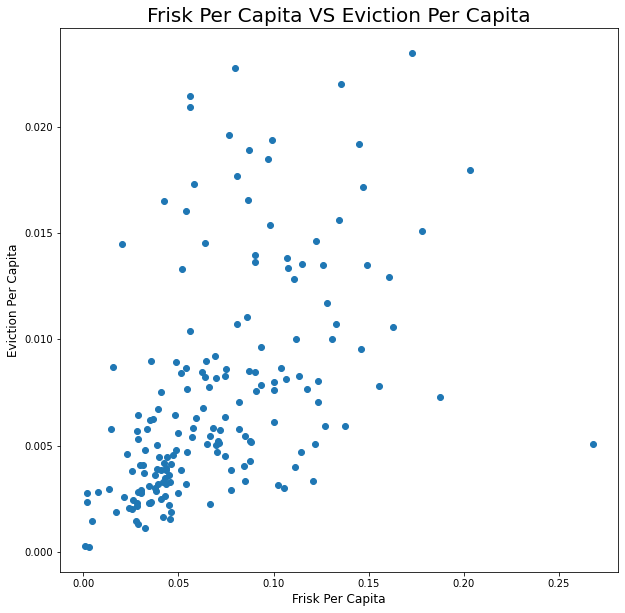

In [38]:
import matplotlib.pyplot as plt

combined2019=combined[combined['year']==2019]

x=combined2019.per_capita_x
y=combined2019.per_capita_y

plt.figure(figsize=(10,10))
plt.scatter(x,y)
plt.title('Frisk Per Capita VS Eviction Per Capita', fontsize=20)
plt.xlabel('Frisk Per Capita', fontsize=12)
plt.ylabel('Eviction Per Capita', fontsize=12)

plt.savefig("frisk_eviction_scatter.png")

plt.show()